In [61]:
from sqlalchemy import create_engine
import pandas as pd
from trainline_traffic_counter_mapping import generate_trainline_counter_mapping, generate_counter_trainline_mapping
from data_transform_utils import get_monthly_avg_day_traffic, get_avg_weekday_traffic_deviations, get_punctuality_of_year

START_YEAR = 2012
END_YEAR   = 2018

# Get db connection for train punctuality
trainline_punc_engine = create_engine('sqlite:///../../data/train_punctuality.sqlite')

# Get all counters
counter_trainline_mapping = generate_counter_trainline_mapping()
all_counters = [counter_key for counter_key in counter_trainline_mapping.keys()]

# Get db connections for all counters
counter_engines = {}
for traffic_counter in all_counters:
    engine = create_engine('sqlite:///../../data/traffic_counter_' + str(traffic_counter) + '.sqlite')
    counter_engines.update({traffic_counter: engine})

# Go through every year and and every counter and calculate 
# different quantiazations for amount of car traffic
monthly_avg_weekday_variances = {}
monthly_avg_workday_variances = {}
monthly_avg_daily_traffic     = {}
monthly_avg_workday_traffic   = {}

# for year in range(2012, 2022):
for year in range(START_YEAR, END_YEAR+1):
    # Create dict key for the year
    monthly_avg_weekday_variances.update({year: {}})
    monthly_avg_workday_variances.update({year: {}})
    monthly_avg_daily_traffic.update({year: {}})
    monthly_avg_workday_traffic.update({year: {}})
    print('Progress: year', year)
    for counter, counter_engine in counter_engines.items():
        try:
            df = pd.read_sql_table(str(year), counter_engine)
        except ValueError:
            # Traffic measurements is not available
            continue
        
        # Retrieve different quantizations of "is there more / less traffic than usual"
        avg_weekday_var     = get_avg_weekday_traffic_deviations(df)
        avg_workday_var     = get_avg_weekday_traffic_deviations(df, only_workdays=True)
        avg_daily_traffic   = get_monthly_avg_day_traffic(df)
        avg_workday_traffic = get_monthly_avg_day_traffic(df, only_workdays=True)
        
        # Add the quantization values for the year and counter respectively
        monthly_avg_weekday_variances.get(year).update({counter: avg_weekday_var})
        monthly_avg_workday_variances.get(year).update({counter: avg_workday_var})
        monthly_avg_daily_traffic.get(year).update({counter: avg_daily_traffic})
        monthly_avg_workday_traffic.get(year).update({counter: avg_workday_traffic})
        
print(monthly_avg_weekday_variances)

Progress: year 2012
Progress: year 2013
Progress: year 2014
Progress: year 2015
Progress: year 2016
Progress: year 2017
Progress: year 2018
{2012: {1154: [811.5392261876211, 848.5683739642526, 987.8398613276862, 1702.92374734136, 3503.017816117634, 1061.628443909746, 2193.754169247954, 927.8032240177781, 1908.2659379664806, 814.4983102759519, 1057.1141798175363, 2407.780733240738], 1156: [707.5350284205712, 472.79534163135844, 686.1025566004118, 1113.8039148228593, 1251.4122202934711, 1130.0696095943538, 381.4845257663701, 554.7007722099135, 272.2525060235443, 621.7155421081605, 324.3190593745838, 1320.7769287325032], 1158: [1144.0348492268188, 694.1913798299109, 780.8332395941649, 1356.505199803351, 1796.2344231831125, 598.3967674334125, 2634.415550716663, 1882.799514983652, 1994.8006006096405, 1635.5814509254735, 591.3321241744812, 2384.026619385507], 1160: [99.65111044685122, 122.25247676033999, 77.66388799451855, 174.13502425670177, 197.09532355973138, 89.24859934370893, 102.785434

In [62]:
# Calculate monthly average lateness from the relevant trainlines for each counter
counter_avg_train_lateness = {}

for year in range(START_YEAR, END_YEAR+1):
    counter_avg_train_lateness.update({year: {}})
    for counter in counter_engines.keys():
        # For every counter, get all relevant trainlines
        relevant_trainlines = counter_trainline_mapping.get(counter)
        # Get monthly punctuality for current year for all relevant trains
        monthly_lateness_values = [[] for i in range(12)]
        for trainline_name in relevant_trainlines:
            trainline_df = pd.read_sql_table(trainline_name, trainline_punc_engine)
            monthly_punctuality_dict = get_punctuality_of_year(trainline_df, year)
            
            for i in range(12):
                punctuality = monthly_punctuality_dict.get(i+1)
                
                #############################################################
                ##TODO: this returns None every time for some reason. Why!??
                
                
                if punctuality is not None:
                    lateness = 100.0 - punctuality
                    monthly_lateness_values[i].append(lateness)
                    # print('Appending', lateness, 'at idx', i)
        
        # Calculate average lateness value of relevant trainlines for each month
        monthly_avg_lateness = [None] * 12
        for i in range(12):
            lateness_values = monthly_lateness_values[i]
            avg_lateness = 0
            if len(lateness_values) > 0:
                avg_lateness = sum(lateness_values) / len(lateness_values)
                monthly_avg_lateness[i] = avg_lateness
        
        # Add avg lateness values of counter to overall dict
        counter_avg_train_lateness.get(year).update({counter: monthly_avg_lateness})
        
print(counter_avg_train_lateness)
        

{2012: {1154: [3.549999999999997, 5.560000000000002, 4.1299999999999955, 4.980000000000004, 8.549999999999997, 6.049999999999997, 4.680000000000007, 4.939999999999998, 6.459999999999994, 9.159999999999997, 10.090000000000003, 7.510000000000005], 1156: [2.969999999999999, 4.959999999999994, 2.930000000000007, 3.739999999999995, 4.480000000000004, 6.680000000000007, 5.8799999999999955, 5.299999999999997, 2.2900000000000063, 6.930000000000007, 4.700000000000003, 5.450000000000003], 1158: [None, None, None, None, None, None, None, None, None, None, None, None], 1160: [17.709999999999994, 21.61, 10.689999999999998, 12.959999999999994, 13.61, 17.299999999999997, 16.209999999999994, 18.700000000000003, 20.790000000000006, 23.739999999999995, 29.489999999999995, 24.239999999999995], 1162: [None, None, None, None, None, None, None, None, None, None, None, None], 1163: [1.509999999999998, 2.9749999999999943, 1.8400000000000034, 4.095000000000006, 3.914999999999999, 5.530000000000001, 2.605000000

In [63]:
# Build all correlations between the different quantizations and the lateness values
#   on a yearly and per counter basis
from scipy.stats import pearsonr

def get_cleaned_vectors(monthly_traffic_quantization: list, monthly_trainline_lateness: list):
    cleaned_monthly_traffic_quant = []
    cleaned_monthly_avg_lateness = []
    # print(monthly_traffic_quantization)
    for i in range(12):
        EPSILON = 0.00001
        if (abs(monthly_traffic_quantization[i]) < EPSILON) or (monthly_trainline_lateness[i] is None):
            continue
        cleaned_monthly_traffic_quant.append(monthly_traffic_quantization[i])
        cleaned_monthly_avg_lateness.append(monthly_trainline_lateness[i])
    assert(len(cleaned_monthly_traffic_quant) == len(cleaned_monthly_avg_lateness))
    return cleaned_monthly_traffic_quant, cleaned_monthly_avg_lateness

def get_pearson_correlation(monthly_traffic_quantization: list, monthly_trainline_lateness: list):
    cleaned_monthly_traffic_quant, cleaned_monthly_avg_lateness = get_cleaned_vectors(monthly_traffic_quantization, monthly_trainline_lateness)
    if len(cleaned_monthly_traffic_quant) < 2:
        return None, None
    pearson_corr, p_value = pearsonr(cleaned_monthly_traffic_quant, cleaned_monthly_avg_lateness)
    return pearson_corr, p_value


avg_weekday_var_correlations = {}
avg_workday_var_correlations = {}
avg_daily_traffic_correlations = {}
avg_workday_traffic_correlations = {}

for year, avg_counter_latenesses in counter_avg_train_lateness.items():
    avg_weekday_var_correlations.update({year: {}})
    avg_workday_var_correlations.update({year: {}})
    avg_daily_traffic_correlations.update({year: {}})
    avg_workday_traffic_correlations.update({year: {}})
    
    for counter, avg_monthly_lateness in avg_counter_latenesses.items():
        #############################################################
        # Avg weekday variance
        monthly_avg_weekday_var = monthly_avg_weekday_variances.get(year).get(counter)
        if monthly_avg_weekday_var is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_weekday_var, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_weekday_var_correlations.get(year).update({counter: (pearson_corr, p_value)})
        
        #############################################################
        # Avg weekday variance
        monthly_avg_workday_var = monthly_avg_workday_variances.get(year).get(counter)
        if monthly_avg_workday_var is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_workday_var, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_workday_var_correlations.get(year).update({counter: (pearson_corr, p_value)})
        
        #############################################################
        # Avg daily traffic
        monthly_avg_daily = monthly_avg_daily_traffic.get(year).get(counter)
        if monthly_avg_daily is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_daily, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_daily_traffic_correlations.get(year).update({counter: (pearson_corr, p_value)})
            
        #############################################################
        # Avg workday traffic
        monthly_avg_workday = monthly_avg_workday_traffic.get(year).get(counter)
        if monthly_avg_workday is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_workday, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_workday_traffic_correlations.get(year).update({counter: (pearson_corr, p_value)})
            

print(avg_weekday_var_correlations)
print(avg_workday_var_correlations)
print(avg_daily_traffic_correlations)
print(avg_workday_traffic_correlations)
        

{2012: {1154: (0.25745170379423693, 0.41918348603782274), 1156: (0.1884100238206202, 0.5575911376503797), 1160: (0.06121765823602171, 0.8500974170992691), 1163: (-0.03334661012622612, 0.9180576279875086), 1164: (0.19269338824610943, 0.5484996914820068), 1165: (0.29882002700308596, 0.34543297489546826), 1166: (0.039953652122758296, 0.9018855296719421), 1167: (0.5996487500745785, 0.03930809405609471), 1170: (-0.07378750614350221, 0.8197253361343346), 1172: (-0.3628663166750828, 0.24634095466619327), 1173: (0.09447498818749361, 0.770247703857849), 1175: (0.14784070260205087, 0.6465696821303333), 1178: (-0.046616706528319826, 0.8856109516840114), 1183: (0.32952663580000374, 0.2955733985564246), 1186: (-0.07868776071497718, 0.8079441338941952), 1187: (0.21318771132105008, 0.5058783993275334), 1190: (-0.23917751724271696, 0.4540451475622652), 1194: (0.18509199628089434, 0.5646756807631826), 1706: (-0.011540348430844893, 0.971604966261674), 1197: (0.001396450751188924, 0.9965634309149256), 11

    correlation_kind  year  counter  pearson_correlation   p_value
0        weekday_var  2012     1154             0.257452  0.419183
1        weekday_var  2012     1156             0.188410  0.557591
2        weekday_var  2012     1160             0.061218  0.850097
3        weekday_var  2012     1163            -0.033347  0.918058
4        weekday_var  2012     1164             0.192693  0.548500
..               ...   ...      ...                  ...       ...
895  workday_traffic  2018     1124             0.696423  0.011865
896  workday_traffic  2018     1125            -0.102084  0.752235
897  workday_traffic  2018     1132             0.286824  0.366057
898  workday_traffic  2018     1133            -0.164852  0.608654
899  workday_traffic  2018     1268             0.596794  0.040502

[900 rows x 5 columns]


<Axes: xlabel='year', ylabel='pearson_correlation'>

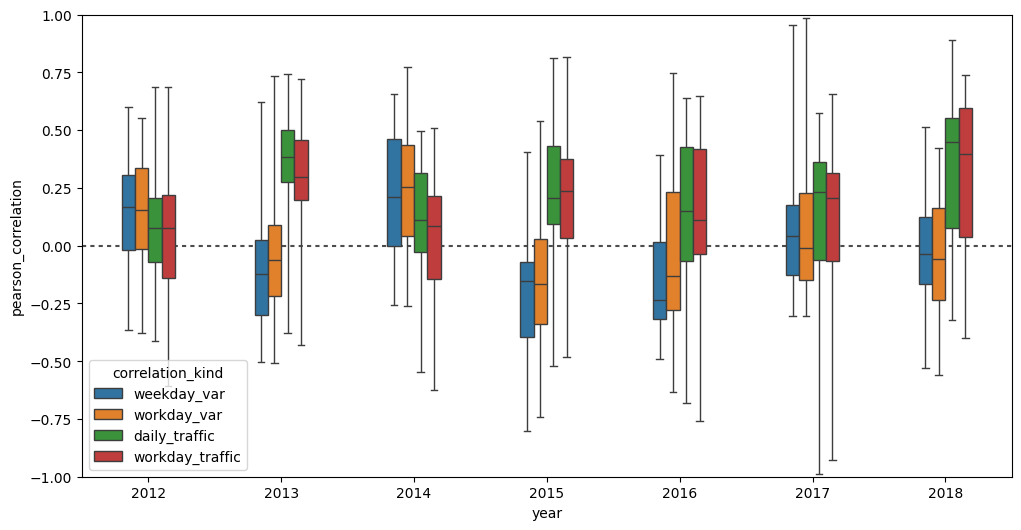

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

boxpl_data = []
for correlation_kind, yearly_correlation_dict in [('weekday_var', avg_weekday_var_correlations), ('workday_var', avg_workday_var_correlations), 
                                                  ('daily_traffic', avg_daily_traffic_correlations), ('workday_traffic', avg_workday_traffic_correlations)]:
    # Convert dictionaries to format for boxplot
    for year, correlation_dict in yearly_correlation_dict.items():
        for counter, correlation in correlation_dict.items():
            row = {'correlation_kind': correlation_kind, 'year': year, 'counter': counter, 'pearson_correlation': correlation[0], 'p_value': correlation[1]}
            boxpl_data.append(row)

boxpl_df = pd.DataFrame(data=boxpl_data)
print(boxpl_df)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([-1, 1])
ax.axhline(0, color=".3", dashes=(2,2))
sns.boxplot(data=boxpl_df, x='year', y='pearson_correlation', hue='correlation_kind', width=0.4, whis=[0, 100])
# sns.stripplot(data=boxpl_df, x='year', y='pearson_correlation', hue='correlation_kind', size=4, color="0.14")
# sns.violinplot(data=boxpl_df, x='year', y='pearson_correlation', hue='correlation_kind', inner_kws=dict(box_width=7, whis_width=1.5))



In [66]:
# Build all correlations between the different quantizations and the lateness values
#   on a yearly basis, combining all counters to one vector

# NOTE: every quantization gets a separate lateness vector, since for some quantizations, different values might be missing / corrupted
#   and the lateness vector needs to be adapted accordingly (and therefore individually)
avg_weekday_var_year_corr_vectors = {'traffic_quantization_vec': {}, 'train_lateness_vec': {}}
avg_workday_var_year_corr_vectors = {'traffic_quantization_vec': {}, 'train_lateness_vec': {}}
avg_daily_traffic_year_corr_vectors = {'traffic_quantization_vec': {}, 'train_lateness_vec': {}}
avg_workday_traffic_year_corr_vectors = {'traffic_quantization_vec': {}, 'train_lateness_vec': {}}

for year, avg_counter_latenesses in counter_avg_train_lateness.items():
    # Add year key to traffic quantization vectors and train lateness vectors
    avg_weekday_var_year_corr_vectors.get('traffic_quantization_vec').update({year: []})
    avg_workday_var_year_corr_vectors.get('traffic_quantization_vec').update({year: []})
    avg_daily_traffic_year_corr_vectors.get('traffic_quantization_vec').update({year: []})
    avg_workday_traffic_year_corr_vectors.get('traffic_quantization_vec').update({year: []})
    
    avg_weekday_var_year_corr_vectors.get('train_lateness_vec').update({year: []})
    avg_workday_var_year_corr_vectors.get('train_lateness_vec').update({year: []})
    avg_daily_traffic_year_corr_vectors.get('train_lateness_vec').update({year: []})
    avg_workday_traffic_year_corr_vectors.get('train_lateness_vec').update({year: []})
    
    for counter, avg_monthly_lateness in avg_counter_latenesses.items():
        
        for avg_traffic_quantization, year_correlation_vectors in [(monthly_avg_weekday_variances, avg_weekday_var_year_corr_vectors), 
                                                                   (monthly_avg_workday_variances, avg_workday_var_year_corr_vectors),
                                                                   (monthly_avg_daily_traffic,     avg_daily_traffic_year_corr_vectors),
                                                                   (monthly_avg_workday_traffic,   avg_workday_traffic_year_corr_vectors)]:

            mon_avg_traffic_quant = avg_traffic_quantization.get(year).get(counter)
            if mon_avg_traffic_quant is not None:
                # Get cleaned traffic quantization and train lateness vector
                cleaned_mon_avg_traffic_quant, cleaned_avg_monthly_lateness = get_cleaned_vectors(mon_avg_traffic_quant, avg_monthly_lateness)
                # Add monthly vector from this counter to vector of all counters for this year
                old_traffic_vec        = year_correlation_vectors.get('traffic_quantization_vec').get(year)
                old_train_lateness_vec = year_correlation_vectors.get('train_lateness_vec').get(year)
                year_correlation_vectors.get('traffic_quantization_vec').update({year: old_traffic_vec + cleaned_mon_avg_traffic_quant})
                year_correlation_vectors.get('train_lateness_vec').update({year: old_train_lateness_vec + cleaned_avg_monthly_lateness})
        
        # #############################################################
        # # Avg weekday variance
        # monthly_avg_weekday_var = monthly_avg_weekday_variances.get(year).get(counter)
        # if monthly_avg_weekday_var is not None:
        #     # Get cleaned vectors
        #     cleaned_monthly_avg_weekday_var, cleaned_avg_monthly_lateness = get_cleaned_vectors(monthly_avg_weekday_var, avg_monthly_lateness)
        #     # Add monthly vector from this counter to vector of all counters for this year
        #     old_traffic_vec        = avg_weekday_var_year_corr_vectors.get('traffic_quantization_vec')
        #     old_train_lateness_vec = avg_weekday_var_year_corr_vectors.get('train_lateness_vec')
        #     avg_weekday_var_year_corr_vectors.get('traffic_quantization_vec').update({year: old_traffic_vec + cleaned_monthly_avg_weekday_var})
        #     avg_weekday_var_year_corr_vectors.get('train_lateness_vec').update({year: old_train_lateness_vec + cleaned_avg_monthly_lateness})
            
        # #############################################################
        # # Avg weekday variance
        # monthly_avg_workday_var = monthly_avg_workday_variances.get(year).get(counter)
        # if monthly_avg_workday_var is not None:
        #     cleaned_monthly_avg_workday_var, cleaned_avg_monthly_lateness = get_cleaned_vectors(monthly_avg_workday_var, avg_monthly_lateness)
            
        #     old_traffic_vec        = avg_workday_var_year_corr_vectors.get('traffic_quantization_vec')
        #     old_train_lateness_vec = avg_workday_var_year_corr_vectors.get('train_lateness_vec')
        #     avg_workday_var_year_corr_vectors.get('traffic_quantization_vec').update({year: old_traffic_vec + cleaned_monthly_avg_workday_var})
        #     avg_workday_var_year_corr_vectors.get('train_lateness_vec').update({year: old_train_lateness_vec + cleaned_avg_monthly_lateness})
             

print(avg_weekday_var_year_corr_vectors)
print(avg_workday_var_year_corr_vectors)
print(avg_daily_traffic_year_corr_vectors)
print(avg_workday_traffic_year_corr_vectors)



{'traffic_quantization_vec': {2012: [811.5392261876211, 848.5683739642526, 987.8398613276862, 1702.92374734136, 3503.017816117634, 1061.628443909746, 2193.754169247954, 927.8032240177781, 1908.2659379664806, 814.4983102759519, 1057.1141798175363, 2407.780733240738, 707.5350284205712, 472.79534163135844, 686.1025566004118, 1113.8039148228593, 1251.4122202934711, 1130.0696095943538, 381.4845257663701, 554.7007722099135, 272.2525060235443, 621.7155421081605, 324.3190593745838, 1320.7769287325032, 99.65111044685122, 122.25247676033999, 77.66388799451855, 174.13502425670177, 197.09532355973138, 89.24859934370893, 102.78543447986615, 100.66867253020234, 65.60575919470169, 139.06063447018622, 76.69433847266554, 300.9928959036169, 702.1365677263587, 575.96403976233, 688.1230877725613, 1497.5349624421349, 2572.0429994743818, 627.0081627010735, 1575.705988754133, 1954.3467191143402, 1132.9316436119204, 972.6353222430556, 682.3860030981775, 1370.0071101246353, 654.8328323980198, 498.8628511027295

In [67]:
# Calculate the correlations for the 4 quantization techniques

yearly_overall_weekday_var_correlations     = {}
yearly_overall_workday_var_correlations     = {}
yearly_overall_daily_traffic_correlations   = {}
yearly_overall_workday_traffic_correlations = {}

for year in range(START_YEAR, END_YEAR+1):
    for year_correlation_vectors in [avg_weekday_var_year_corr_vectors, avg_workday_var_year_corr_vectors,
                                    avg_daily_traffic_year_corr_vectors, avg_workday_traffic_year_corr_vectors]:
        
        traffic_vector = year_correlation_vectors.get('traffic_quantization_vec').get(year)
        train_lateness_vector = year_correlation_vectors.get('train_lateness_vec').get(year)
        assert(len(traffic_vector) == len(train_lateness_vector))
        pearson_corr, p_value = pearsonr(traffic_vector, train_lateness_vector)
        
        print('For year', year, 'Correlation:', pearson_corr, 'with p_value:', p_value)
        
        
# Result is not great

For year 2012 Correlation: 0.037581293554377185 with p_value: 0.43590631688673553
For year 2012 Correlation: 0.045037769278980996 with p_value: 0.35037912168207613
For year 2012 Correlation: 0.05022834406902937 with p_value: 0.29759285132437635
For year 2012 Correlation: 0.0441216957679027 with p_value: 0.3602752371765303
For year 2013 Correlation: -0.058496918436605885 with p_value: 0.22499522775883352
For year 2013 Correlation: -0.04986427834980118 with p_value: 0.3011127607881545
For year 2013 Correlation: 0.018432171841829794 with p_value: 0.7024406306994505
For year 2013 Correlation: 0.009630836284766449 with p_value: 0.8417951289859156
For year 2014 Correlation: 0.021595250915987043 with p_value: 0.6540656229534959
For year 2014 Correlation: 0.0354091625682776 with p_value: 0.4623897200243985
For year 2014 Correlation: -0.00043760765276823363 with p_value: 0.9927555445241747
For year 2014 Correlation: -0.004080991184684817 with p_value: 0.9325199291229438
For year 2015 Correlatio